In [1]:
from erbium_data.erbium_data_importer import ScanImporter
from erbium_analysis_modules.fluorescence_analysis_module import FluorescenceAnalysisModule
from scipy.ndimage import gaussian_filter
from erbium_analysis_methods.results import get_real_variables_and_units
from physics.atom import Erbium
from scipy import optimize
from erbium_analysis.analysis_run_file import AnalysisRunFile
from erbium_analysis_modules.lattice_fitting_module import LatticeFittingModule
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pickle
from erbium_results.squeezing import get_occupations_from_scan
from erbium_analysis_modules.lattice_analysis_util import LatticeAnalysisUtil

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import copy

def get_std(image):
    return np.std(image)

def get_max(image,sigma,alpha=20,size=10,gaussian_filter_sigma=2):
    image=gaussian_filter(image, sigma=gaussian_filter_sigma)
    i_out = []
    j_out = []
    image_temp = copy.deepcopy(image)
    while True:
        k = np.argmax(image_temp)
        j,i = np.unravel_index(k, image_temp.shape)
        if(image_temp[j,i] >= alpha*sigma):
            i_out.append(i)
            j_out.append(j)
            x = np.arange(i-size, i+size)
            y = np.arange(j-size, j+size)
            xv,yv = np.meshgrid(x,y)
            image_temp[yv.clip(0,image_temp.shape[0]-1),
                                   xv.clip(0,image_temp.shape[1]-1) ] = 0
            # print(xv)
        else:
            break
            
    result = np.array([i_out, j_out])
    filtered_result=result[:, (result[1]>size*2) * (result[1]<image_temp.shape[0]-(size*2)) * (result[0]>size*2) * (result[0]<image_temp.shape[1]-(size*2))]
    return filtered_result

In [3]:
def lattice(p, shape):
    data = np.transpose(LatticeAnalysisUtil.generate_lattice_from_k_data([[p[0], p[1]], [[p[2], p[3]], [p[4], p[5]]]], shape))
    return data[1], data[0]

def lattice_k_cost(p, x, shape):
    cost=0
    lattice_val=np.transpose(lattice(p, shape))
    for index in range(len(x)):
        cost+=np.amin(np.linalg.norm(lattice_val-[x[index][0],x[index][1]],axis=1))**2
    return cost/len(x)

In [4]:
def get_image(scan_index, directory, background_average_image, Roi=None, binarized=False, Threshold=530, exclusions=[], index=0):
    if Roi is None:
        Roi=[[0, 512], [0, 512]]

    importer = ScanImporter(directory=directory)
        
    scan = importer.get_scan_by_index(scan_index)
    analysis_run_file = AnalysisRunFile(scan, visualization_results_directory = '')
    analysis_run_file.add_analysis_module(FluorescenceAnalysisModule(analysis_run_file = analysis_run_file,
                                                                  roi = Roi,
                                                                  threshold = Threshold,
                                                                  atom = Erbium.Erbium168(),
                                                                  display_results = False,
                                                                  save_figures = False,
                                                                  run_default_visualization_modules=False,
                                                                  exclusions=exclusions, save_numpy=False,
                                                                  index=index))
    analysis_run_file.run()
    anmod = analysis_run_file.get_analysis_module(FluorescenceAnalysisModule)
    images = []
    for key, val in anmod.results.results.items():
        if binarized:
            images.append(val['Binarized Image'])
        elif (val['Raw Image'] < 500+1000*500/4.31).all():
            images.append(val['Raw Image'])
        else:
            plt.imshow(val['Raw Image'])
            plt.show()
            plt.close()
            print("Discarding {}".format(key))
    atom_average_image=np.mean(images, axis=0)
    
    if len(background_average_image.shape)==3:
        image=atom_average_image-background_average_image[Roi[0][0]:Roi[0][1],Roi[1][0]:Roi[1][1], index]
    else:
        image=atom_average_image-background_average_image[Roi[0][0]:Roi[0][1],Roi[1][0]:Roi[1][1]]
    return image

In [5]:
def get_images(scan_index, directory, Roi=None, Threshold=530, exclusions=[]):
    if Roi is None:
        Roi=[[0, 512], [0, 512]]

    importer = ScanImporter(directory=directory)
    
    # background
    background_scan_index=scan_index
    background_average_image_raw = FluorescenceAnalysisModule.get_background_image(directory=directory, scan_index=background_scan_index, imgidx=2)
    background_average_image = gaussian_filter(background_average_image_raw, sigma=10)
    background_scan_dir=directory
    
    ims = []
    for index in range(3):
        scan = importer.get_scan_by_index(scan_index)
        analysis_run_file = AnalysisRunFile(scan, visualization_results_directory = '')
        analysis_run_file.add_analysis_module(FluorescenceAnalysisModule(analysis_run_file = analysis_run_file,
                                                                      roi = Roi,
                                                                      threshold = Threshold,
                                                                      atom = Erbium.Erbium168(),
                                                                      display_results = False,
                                                                      save_figures = False,
                                                                      run_default_visualization_modules=False,
                                                                      exclusions=exclusions, save_numpy=False,
                                                                      index=index))
        analysis_run_file.run()
        anmod = analysis_run_file.get_analysis_module(FluorescenceAnalysisModule)
        ims.append(np.array([ (r["Raw Image"]-background_average_image[Roi[0][0]:Roi[0][1],Roi[1][0]:Roi[1][1]]) for r in anmod.results.results.values() ]))
    ims = np.array(ims)

    return ims

In [6]:
def optimize_lattice(scan_index, p_fft, directory, background_average_image, alpha=1.8, image_index=1):
    p0=[p_fft[0][0],p_fft[0][1],p_fft[1][0][0],p_fft[1][0][1],p_fft[1][1][0],p_fft[1][1][1]]
    # p0=[-.5,-2.5,8.415,5.325,-5.195,8.51]
    image = get_image(scan_index, directory, background_average_image, index=image_index)

    half_width=int(.71*np.amin([p0[2]**2+p0[4]**2, p0[3]**2+p0[5]**2])**.5)+1

    #computing the standard deviation of the image
    sigma = get_std(image)
    #getting the peaks
    i,j = get_max(image,sigma, alpha=alpha, size=half_width, gaussian_filter_sigma=3)

    mask = (i > 50) & (j > 50)
    i = i[mask]
    j = j[mask]

    #let's see the results
    plt.imshow(image, origin='lower')
    plt.plot(i,j,'ro', markersize=2, alpha=0.5)
    plt.show()

    plt.plot(i,j,'ro', markersize=2, alpha=0.5)
    plt.plot(*lattice(p0, image.shape),'bo', markersize=1, alpha=0.5)
    plt.xlim(0,512)
    plt.ylim(0,512)
    plt.show()
    print(lattice_k_cost(p0, np.transpose([i,j]), image.shape))

    res = optimize.minimize(lattice_k_cost, p0, args = (np.transpose([i,j]), image.shape), method='SLSQP',
                            bounds=((p0[0]-1.5*np.pi, p0[0]+1.5*np.pi),(p0[1]-1.5*np.pi, p0[1]+1.5*np.pi),(p0[2]*.9,p0[2]*1.1),(p0[3]*.9,p0[3]*1.1),(p0[4]*1.1,p0[4]*0.9),(p0[5]*.9,p0[5]*1.1)))
    print(res)

    plt.plot(i,j,'ro', markersize=2, alpha=0.5)
    plt.plot(*lattice(res['x'], image.shape),'bo', markersize=1, alpha=0.5)
    plt.xlim(0,512)
    plt.ylim(0,512)
    plt.show()

    p=res['x']
    lattice_k_data =  [[ p[0], p[1]], [[ p[2],  p[3]], [p[4],  p[5]]] ]
    
    return lattice_k_data

In [16]:
def get_occupations(scan_index, lattice_k_data, directory, background_average_image, thresholds=(5, 5, 9)):
    count_extraction_options = {'scan_index': scan_index, 
                                'directory': directory, 
                                'background_scan_index': None,
                                'background_average_image_override': background_average_image,
                                'run_default_visualization_modules': False,
                                'lattice_k_data': lattice_k_data,
                                'bad_shot': np.array([]),
                                'p_idx': 134,
                                'box_width': 7, # in px
                                'photon_counting': True, 
                                'th_sigma_above_mean': 3.}

    occupations, occupation_matrix_mask \
          = get_occupations_from_scan(count_extraction_options, 
                                      number_images = 3,
                                      do_plot=False,thresholds=thresholds)
    
    units, variable_values = get_real_variables_and_units(directory, scan_index)
    try: 
        del units['DMDRampDuration1']
        del units['DMDRampDuration0']
        del variable_values['DMDRampDuration1']
        del variable_values['DMDRampDuration0']
    except:
        pass
    
    return occupations, (units, variable_values)

In [8]:
def process(directory, scan_index, p_fft=None, savedir=None, lattice_shot_index=2, alpha=1.8, EMCCDgain=1000):
    importer = ScanImporter(directory=directory)
    
    if savedir is not None and not os.path.isdir(savedir):
        os.makedirs(savedir)
    
    # background
    background_scan_index=scan_index
    background_average_image_raw = FluorescenceAnalysisModule.get_background_image(directory=directory, scan_index=background_scan_index, imgidx=2)
    background_average_image = gaussian_filter(background_average_image_raw, sigma=10)
    background_scan_dir=directory

    if p_fft is None:
        # lattice initial fit
        analysis_run_file = AnalysisRunFile(importer.get_scan_by_index(scan_index).shots[lattice_shot_index])
        roi_center = [256, 256]  # x, y
        roi_width = 512
        roi = [[roi_center[1]-roi_width//2, roi_center[1]+roi_width//2],
                [roi_center[0]-roi_width//2, roi_center[0]+roi_width//2]]
        analysis_options = {'threshold' : 530,
                        'atom' : Erbium.Erbium168(),
                        'display_results' : False,
                        'save_figures' : False,
                        'camera_name':"IXon",
                        'run_default_visualization_modules':False}
        analysis_run_file.add_analysis_module(FluorescenceAnalysisModule(analysis_run_file=analysis_run_file,
                                                                             roi=roi,
                                                                             **analysis_options))
        lattice_module = LatticeFittingModule(analysis_run_file=analysis_run_file, Debug=False, run_default_visualization_modules=False)
        analysis_run_file.add_analysis_module(lattice_module)
        analysis_run_file.run()

        p_fft = lattice_module.get_results_list_by_index("kData", [lattice_shot_index])[0][0]
    
    lattice_k_data = optimize_lattice(scan_index, p_fft, directory, background_average_image, alpha=alpha)

    occs, (units, variable_values) = get_occupations(scan_index, lattice_k_data, directory, background_average_image)

    print("Occupations shape:", occs.shape)
    mean_occs = np.mean(np.sum(occs, axis=0), axis=-1)
    c = plt.imshow(mean_occs)
    plt.title("Mean occupation")
    plt.colorbar(c)

    if savedir is not None:
        pickle.dump({ "occs": occs, "units": units, "variable_values": variable_values }, open(os.path.join(savedir, str(scan_index) + ".pickle"), "wb"))

FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeFittingModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
FluorescenceAnalysisModule running...
	 Running on Shot# 2470 


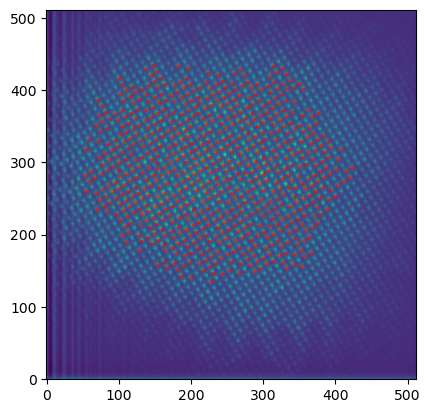

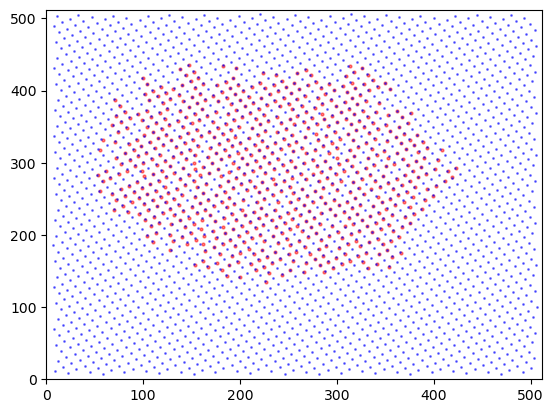

1.7192461363385285


C:\Users\ahebe\Anaconda3\envs\tf\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.7126579077797541
       x: [-1.206e+00 -9.806e-01  8.426e+00  5.313e+00 -5.196e+00
            8.479e+00]
     nit: 9
     jac: [ 5.373e-04  9.228e-05  4.343e-04 -2.388e-03  9.384e-04
           -1.322e-03]
    nfev: 75
    njev: 9


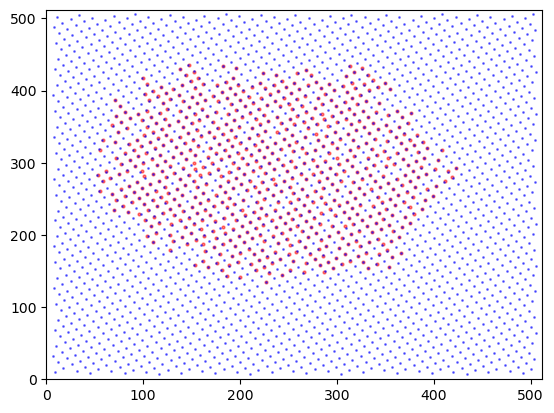

FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
Occupations shape: (3, 69, 69, 2471)


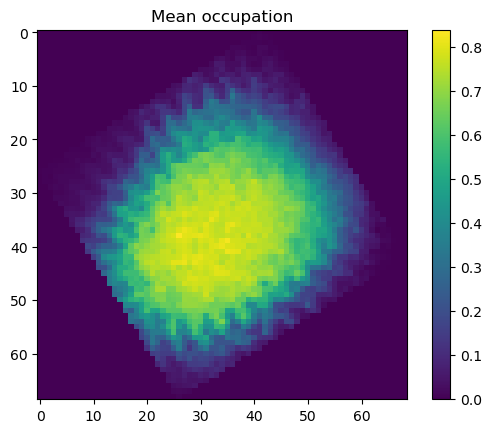

In [50]:
process('Z:\\LogFiles\\2023\\12\\05', 77, savedir="./data/2023/12/05/")
#    [[-0.00141249,-0.25802931], [[ 8.49573776, 5.37548124],
#     [-5.04730445, 8.43276195]], ])

FluorescenceAnalysisModule running...
	 Running on Shot# 887 


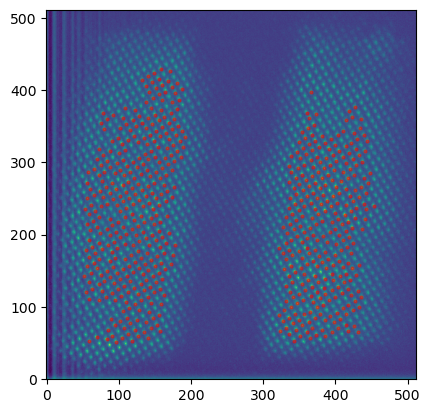

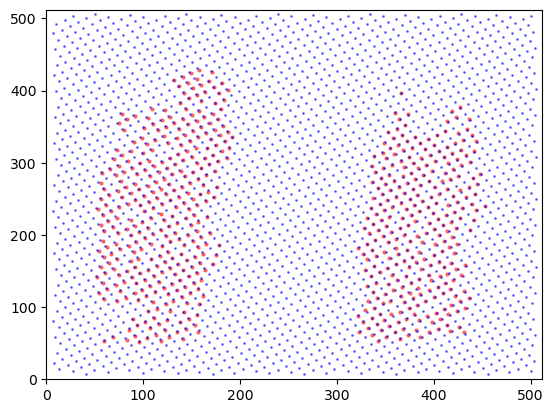

2.3179962686346425
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.6518721342941582
       x: [-1.069e+00  1.142e+00  8.427e+00  5.333e+00 -5.211e+00
            8.496e+00]
     nit: 8
     jac: [-1.238e-05 -8.948e-06 -1.608e-04 -7.529e-05 -5.117e-05
            1.228e-05]
    nfev: 69
    njev: 8


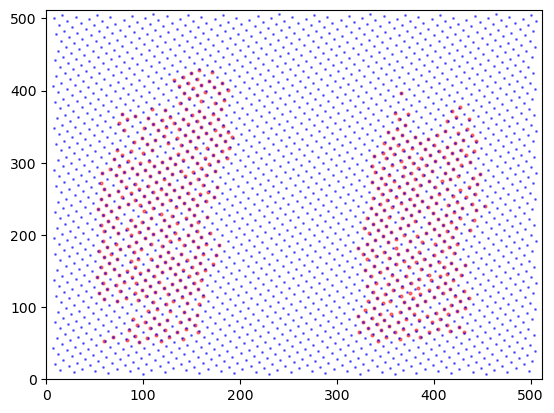

FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
Occupations shape: (3, 69, 68, 888)


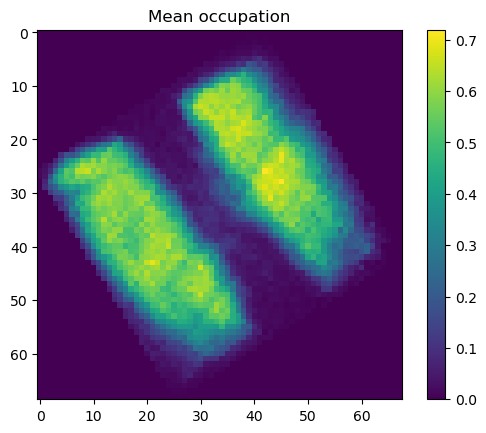

In [51]:
process('Z:\\LogFiles\\2023\\12\\08', 27, savedir="./data/2023/12/08/", p_fft=[[-1.42328408, 1.12800242], [[ 8.44413289, 5.29169845],
 [-5.27372411, 8.53424697]], ])

FluorescenceAnalysisModule running...
	 Running on Shot# 319 


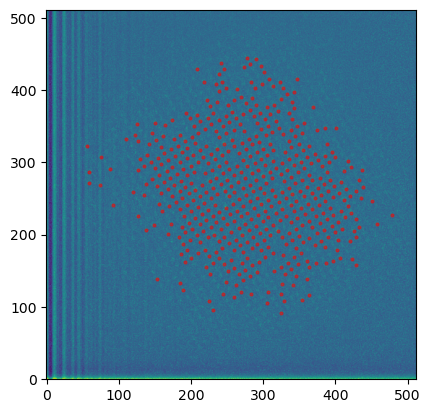

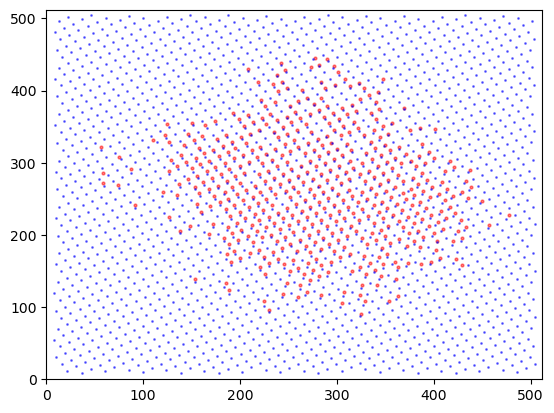

15.976873384273112
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.088340995717952
       x: [ 5.691e-01 -3.606e+00  9.261e+00  5.844e+00 -5.725e+00
            9.357e+00]
     nit: 10
     jac: [ 1.007e-05 -3.737e-05 -2.521e-04 -2.390e-04  2.060e-04
            1.736e-04]
    nfev: 83
    njev: 10


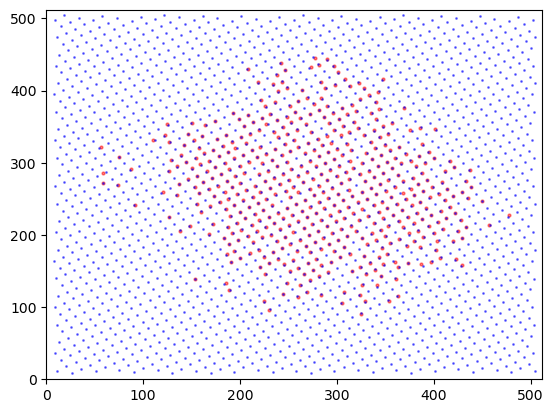

FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
Occupations shape: (3, 63, 62, 320)


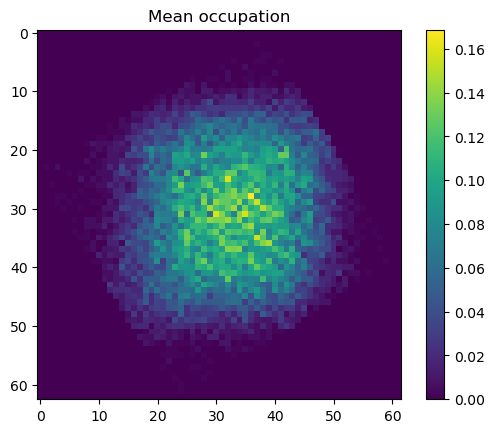

In [17]:
process('Z:\\LogFiles\\2024\\03\\19', 80, savedir="./data/2024/03/19/", p_fft=[ [2.44233808, -2.48519192],  [[9.32296948, 5.90237438], [-5.62151317,  9.31007887]], ], alpha=0.5)

FluorescenceAnalysisModule running...
	 Running on Shot# 319 


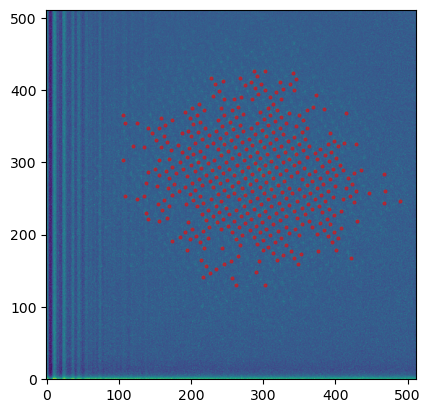

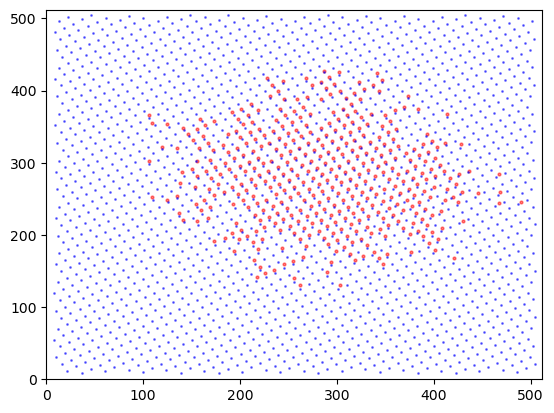

16.2076044732278
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.03368638676634
       x: [ 4.533e-01 -3.610e+00  9.261e+00  5.856e+00 -5.721e+00
            9.347e+00]
     nit: 10
     jac: [ 2.055e-05 -2.217e-05 -1.253e-04 -7.579e-05  1.034e-05
           -7.078e-06]
    nfev: 83
    njev: 10


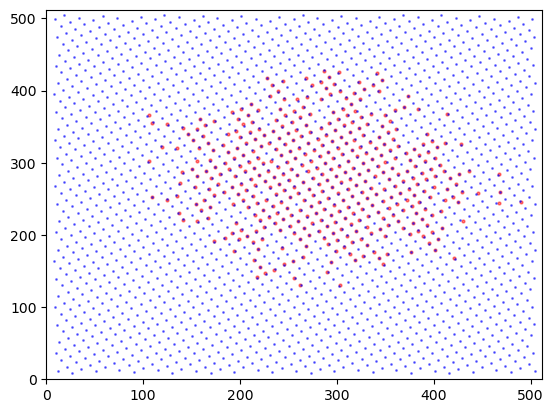

FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
Occupations shape: (3, 63, 62, 320)


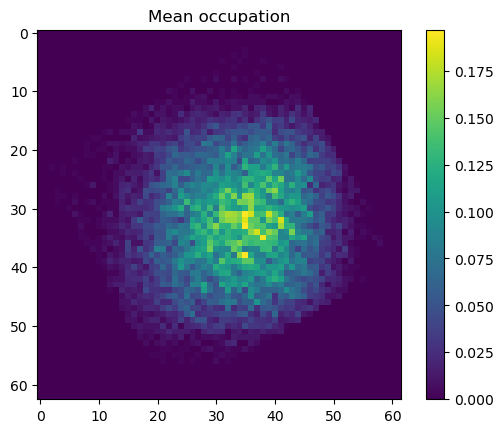

In [18]:
process('Z:\\LogFiles\\2024\\03\\19', 109, savedir="./data/2024/03/19/", 
        p_fft=[ [2.44233808, -2.48519192],  [[9.32296948, 5.90237438], [-5.62151317,  9.31007887]], ], alpha=0.5)

FluorescenceAnalysisModule running...
	 Running on Shot# 319 


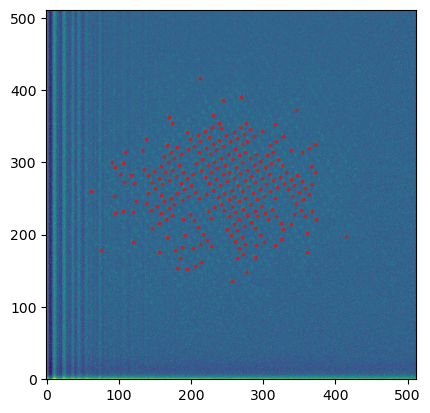

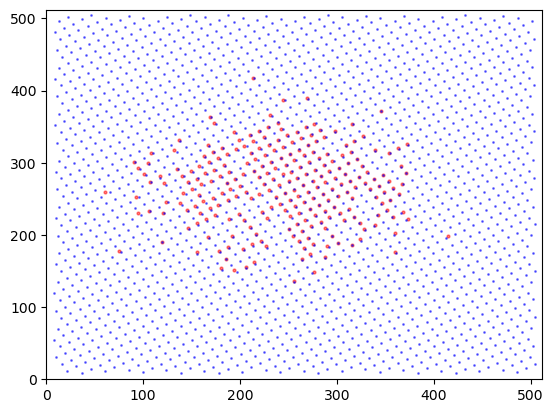

3.284708126927976
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.040644485819893
       x: [ 1.778e+00 -2.321e+00  9.269e+00  5.846e+00 -5.720e+00
            9.365e+00]
     nit: 9
     jac: [-3.237e-04  1.336e-04  6.486e-04 -5.195e-04 -1.878e-03
            1.029e-03]
    nfev: 74
    njev: 9


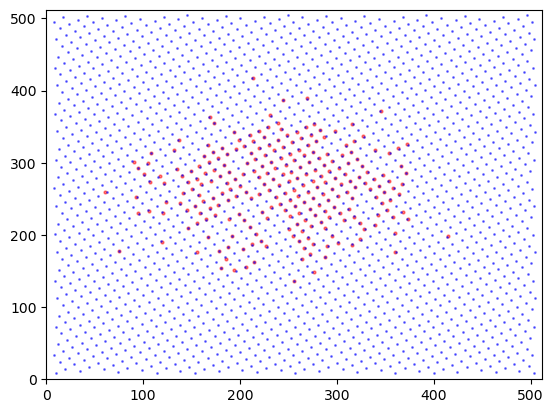

FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
FluorescenceAnalysisModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
LatticeCountModule running...
	 Running on <class 'erbium_data.erbium_data.Shot'>
Using background image override
Occupations shape: (3, 63, 62, 320)


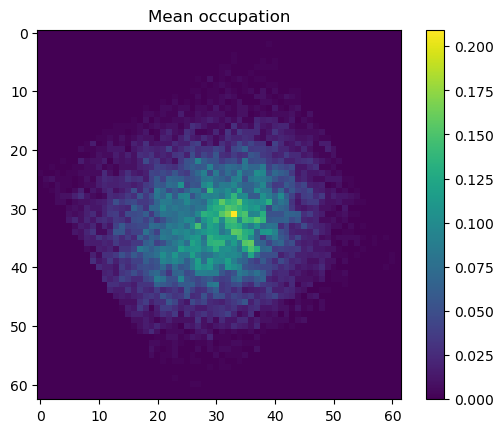

In [19]:
process('Z:\\LogFiles\\2024\\03\\15', 113, savedir="./data/2024/03/15/", p_fft=[ [2.44233808, -2.48519192],  [[9.32296948, 5.90237438], [-5.62151317,  9.31007887]], ], alpha=0.5)

In [20]:
process('Z:\\LogFiles\\2024\\02\\02', 40, savedir="./data/2024/02/02/", 
        p_fft=[ [0.95330856,  2.9162757],  [[12.58059042,  8.04881312], [-7.74347988, 12.81506557]],], alpha=0.5)

FluorescenceAnalysisModule running...



KeyboardInterrupt



In [ ]:
process('Z:\\LogFiles\\2024\\02\\02', 18, savedir="./data/2024/02/02/", 
        p_fft=[ [0.95330856,  2.9162757],  [[12.58059042,  8.04881312], [-7.74347988, 12.81506557]],], alpha=0.5)

In [ ]:
process('Z:\\LogFiles\\2024\\02\\01', 179, savedir="./data/2024/02/01/", 
        p_fft=[ [0.95330856,  2.9162757],  [[12.58059042,  8.04881312], [-7.74347988, 12.81506557]],], alpha=0.5)

In [ ]:
process('Z:\\LogFiles\\2024\\03\\20', 156, savedir="./data/2024/03/20/", 
        p_fft=[ [2.44233808, -2.48519192],  [[9.32296948, 5.90237438], [-5.62151317,  9.31007887]], ], alpha=0.5)

In [ ]:
process('Z:\\LogFiles\\2024\\03\\19', 138, savedir="./data/2024/03/19/", 
        p_fft=[ [2.44233808, -2.48519192],  [[9.32296948, 5.90237438], [-5.62151317,  9.31007887]], ], alpha=0.5)

In [ ]:
process('Z:\\LogFiles\\2024\\03\\18', 111, savedir="./data/2024/03/18/", 
        p_fft=[ [2.44233808, -2.48519192],  [[9.32296948, 5.90237438], [-5.62151317,  9.31007887]], ], alpha=0.5)

In [ ]:
process('Z:\\LogFiles\\2024\\03\\17', 58, savedir="./data/2024/03/17/", 
        p_fft=[ [2.44233808, -2.48519192],  [[9.32296948, 5.90237438], [-5.62151317,  9.31007887]], ], alpha=0.5)

In [ ]:
process('Z:\\LogFiles\\2024\\02\\10', 68, savedir="./data/2024/02/10/", 
        p_fft=[ [2.44233808, -2.48519192],  [[9.32296948, 5.90237438], [-5.62151317,  9.31007887]], ], alpha=0.5)

In [ ]:
process('Z:\\LogFiles\\2024\\02\\10', 69, savedir="./data/2024/02/10/", 
        p_fft=[ [3.100e+00, -5.065e+00],  [[9.261e+00,  5.898e+00],[ -5.706e+00, 9.379e+00]],], alpha=0.5)f

In [ ]:
process('Z:\\LogFiles\\2023\\12\\04', 37, savedir="./data/2023/12/04/", p_fft=[[-1.42328408, 1.12800242], [[ 8.44413289, 5.29169845],
 [-5.27372411, 8.53424697]], ], alpha=0.5)

In [ ]:
process('Z:\\LogFiles\\2023\\12\\05', 34, savedir="./data/2023/12/05/", p_fft=[[-1.42328408, 1.12800242], [[ 8.44413289, 5.29169845],
 [-5.27372411, 8.53424697]], ], alpha=1)